In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import attention
import transformers
import torch

import helper
from helper import *

In [2]:
df = load_and_preprocess()
df = df.reset_index(drop = True)

In [3]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

### Simple LSTM Model

In [5]:
df['Temperature'] = df['Temperature']-273.15 #convert from K to C
df.head()

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01 13:00:00,heavy clouds,93.0,1001.0,12.680000,230.0,4.0,1,0,0,0,0,0,0,0,3.0
1,2012-10-01 14:00:00,sky is clear,91.0,986.0,12.684650,230.0,4.0,0,0,0,0,0,0,0,0,0.0
2,2012-10-01 15:00:00,sky is clear,87.0,945.0,12.697790,231.0,4.0,0,0,0,0,0,0,0,0,0.0
3,2012-10-01 16:00:00,sky is clear,84.0,904.0,12.710929,233.0,4.0,0,0,0,0,0,0,0,0,0.0
4,2012-10-01 17:00:00,sky is clear,80.0,863.0,12.724069,234.0,3.0,0,0,0,0,0,0,0,0,0.0


Splitting the dataframe into 75% training data (first 75% of observations), and 25% testing.

In [6]:
train = df[:cutoff].reset_index(drop = True)
train = train.iloc[:, 4:5].values
test = df[cutoff:]
test = test.iloc[:, 4:5].values

In [7]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

Splits the sequence (`Temperature` column here) to pass into an LSTM model.<br>
Takes the column as input as well as the number of observations that should be in each X vector.

In [8]:
def split(sequence, n_timestamp):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], sequence[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [9]:
X_train, y_train = split(sequence = train_std, n_timestamp = 10)
X_test, y_test = split(sequence = test_std, n_timestamp = 10)

In [10]:
print(X_train.shape)
print(X_test.shape)

(33929, 10, 1)
(11303, 10, 1)


In [11]:
print(y_train.shape)
print(y_test.shape)

(33929, 1)
(11303, 1)


Simple LSTM model

In [12]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [13]:
model.compile(loss = 'mse', optimizer = 'adam')

In [14]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
849/849 [==============================] - 8s 7ms/step - loss: 0.0644 - val_loss: 0.0350
Epoch 2/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0152 - val_loss: 0.0089
Epoch 3/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0111 - val_loss: 0.0084
Epoch 4/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 5/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0108 - val_loss: 0.0082
Epoch 6/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 7/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0108 - val_loss: 0.0076
Epoch 8/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 9/20
849/849 [==============================] - 5s 5ms/step - loss: 0.0107 - val_loss: 0.0070
Epoch 10/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0106 - val_loss: 0.0069

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_test_inv = sc.inverse_transform(y_test)
y_pred_inv = sc.inverse_transform(y_pred)

Plot of actual temperatures and predicted temperatures in a small sample of days (first year of test data)

In [24]:
y_test_inv[0:365].max()

29.420000000000016

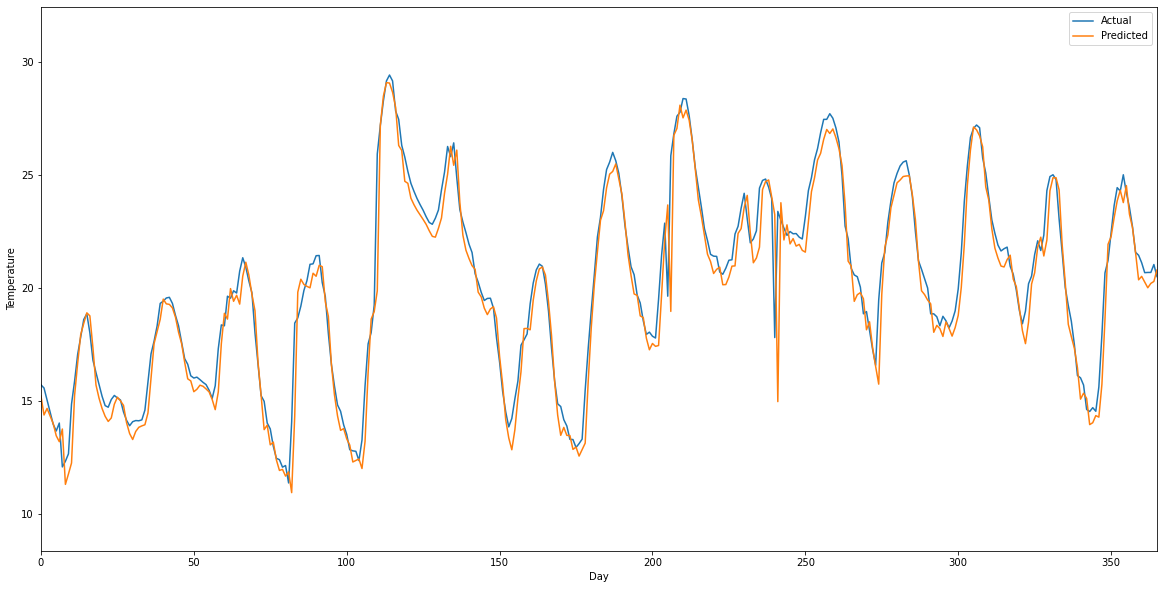

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [28]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 0.992087255909956
R-Squared: 0.991673748710047
RMSE: 0.9960357703968046


MSE and RMSE are about 1. Will compare to more advanced models below.

### Multivariate Predictions

Splits data into sequences of input variables and corresponding target variable.

In [29]:
def split_multiple(sequence, n_timestamp, target):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], target[end] #takes up to n-1 observations in all sequence columns, and the nth observation of the target
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

Using all numerical variables as inputs and temperature as target.

In [30]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.drop(['datetime', 'Description'], axis = 1).values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.drop(['datetime', 'Description'], axis = 1).values

In [31]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [32]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [33]:
X_train.shape

(33929, 10, 14)

In [34]:
y_train.shape

(33929, 1)

In [35]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [36]:
model.compile(loss = 'mse', optimizer = 'adam')

In [37]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
849/849 [==============================] - 8s 6ms/step - loss: 0.1231 - val_loss: 0.0933
Epoch 2/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0345 - val_loss: 0.0410
Epoch 3/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0188 - val_loss: 0.0181
Epoch 4/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 5/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0121 - val_loss: 0.0101
Epoch 6/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0118 - val_loss: 0.0101
Epoch 7/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 8/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 9/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0117 - val_loss: 0.0111


In [38]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [39]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

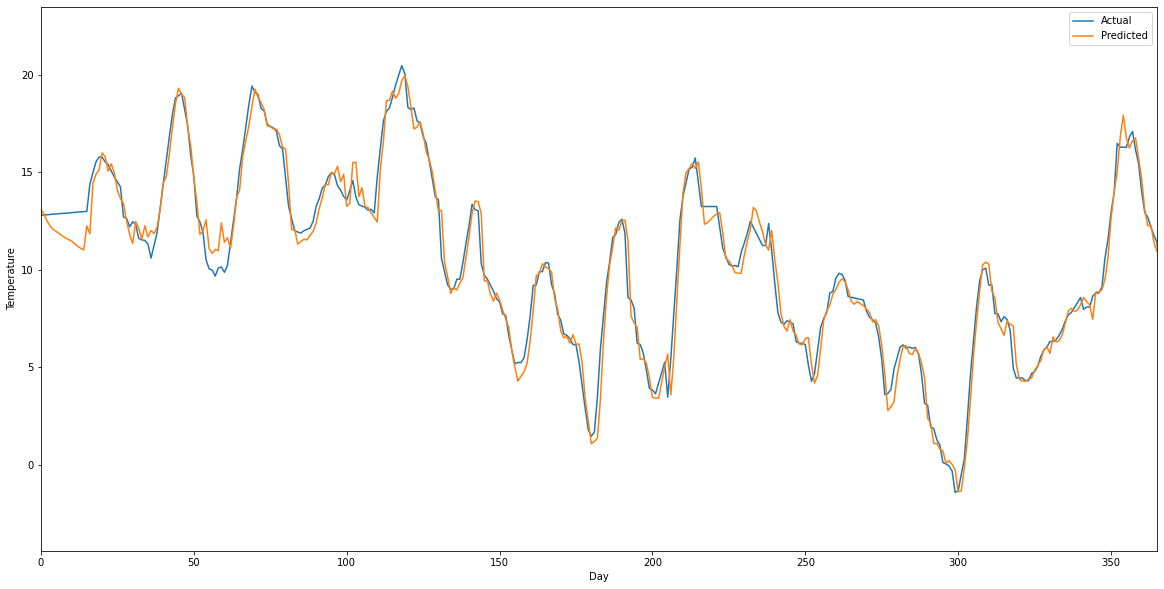

In [40]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [41]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 2.267161601001386
R-Squared: 0.9848876191391969
RMSE: 1.5057096669017525


Interestingly, this performs slightly worse than the simpler model. Previous temperatures are the most important indicator of future temperatures, so this makes sense.

### Incorporating Engineered Features

Using engineered features and the 20 most important features as per our RFE analysis.

In [43]:
df = feature_engineer_important(load_and_preprocess())

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


In [44]:
df['datetime'] = pd.to_datetime(df.index)
df = df.dropna()
df['Temperature'] = df['Temperature']-273.15 #convert from K to C

This starts a week after the original dataframe because there are some lagging variables which do not exist for the first observations. This dataset contains data from over 5 years, so one week is not a big deal to drop.

In [45]:
df.head()

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,11.82,2012-10-09 19:00:00
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,12.43,2012-10-09 20:00:00
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,12.60,2012-10-09 21:00:00
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,11.89,2012-10-09 22:00:00
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,8.58,2012-10-09 23:00:00


#### LSTM with New Features <br>
Using all the numerical features from above

In [46]:
train = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [47]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [48]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [49]:
X_train.shape

(33929, 10, 21)

In [50]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [51]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
849/849 [==============================] - 9s 7ms/step - loss: 0.1191 - val_loss: 0.0932
Epoch 2/20
849/849 [==============================] - 6s 7ms/step - loss: 0.0524 - val_loss: 0.0466
Epoch 3/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0251 - val_loss: 0.0410
Epoch 4/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0194 - val_loss: 0.0282
Epoch 5/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0182 - val_loss: 0.0196
Epoch 6/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0189 - val_loss: 0.0153
Epoch 7/20
849/849 [==============================] - 6s 7ms/step - loss: 0.0145 - val_loss: 0.0175
Epoch 8/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0140 - val_loss: 0.0129
Epoch 9/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0097 - val_loss: 0.0131
Epoch 10/20
849/849 [==============================] - 5s 6ms/step - loss: 0.0093 - val_loss: 0.0109

In [52]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [53]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

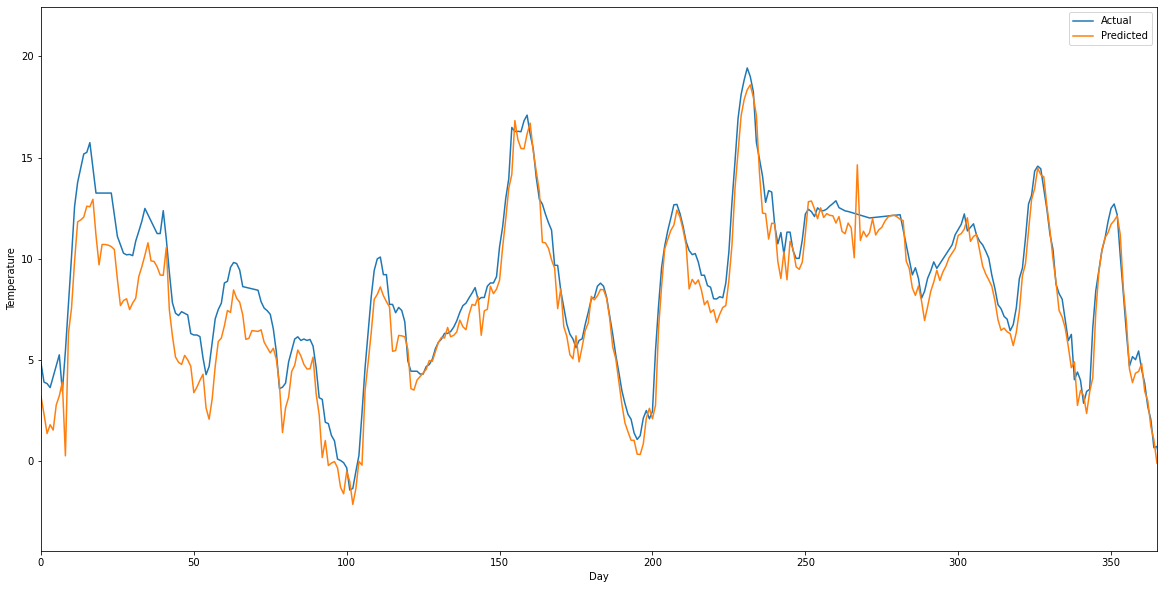

In [54]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [55]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 2.263089024639545
R-Squared: 0.9849756141332603
RMSE: 1.5043566813224665


Not quite as performant as the original model.

### Transformers

Full disclosure, transformers are a completely novel concept, and the examples that we could find online were nearly exclusively for text-based problems.

#### Attention Model<br>
LSTM with an attention layer.

In [56]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()
df['Temperature'] = df['Temperature']-273.15

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


In [57]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff
df.head()

,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,11.82
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,12.43
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,12.60
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,11.89
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,8.58


In [58]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [59]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [60]:
X_train, y_train = split_multiple(train_std, 24, target_train_std)
X_test, y_test = split_multiple(test_std, 24, target_test_std)
X_train.shape

(33766, 24, 21)

In [61]:
model_input = keras.Input(shape = X_train.shape[1:])
x = keras.layers.LSTM(50, return_sequences = True)(model_input)
x = keras.layers.LSTM(50, return_sequences = True)(x)
x = attention.Attention()(x) #incorportating an attention layer in the model
model_output = keras.layers.Dense(1)(x)
model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 21)]     0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 24, 50)       14400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 24, 50)       20200       lstm_6[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 50)           0           lstm_7[0][0]                     
______________________________________________________________________________________________

In [62]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
845/845 [==============================] - 14s 13ms/step - loss: 0.1354 - val_loss: 0.0771
Epoch 2/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0704 - val_loss: 0.0323
Epoch 3/20
845/845 [==============================] - 11s 13ms/step - loss: 0.0378 - val_loss: 0.0286
Epoch 4/20
845/845 [==============================] - 11s 13ms/step - loss: 0.0244 - val_loss: 0.0270
Epoch 5/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0178 - val_loss: 0.0215
Epoch 6/20
845/845 [==============================] - 11s 13ms/step - loss: 0.0186 - val_loss: 0.0156
Epoch 7/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0201 - val_loss: 0.0139
Epoch 8/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0166 - val_loss: 0.0100
Epoch 9/20
845/845 [==============================] - 10s 12ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 10/20
845/845 [==============================] - 11s 13ms/step - loss: 0.012

In [63]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

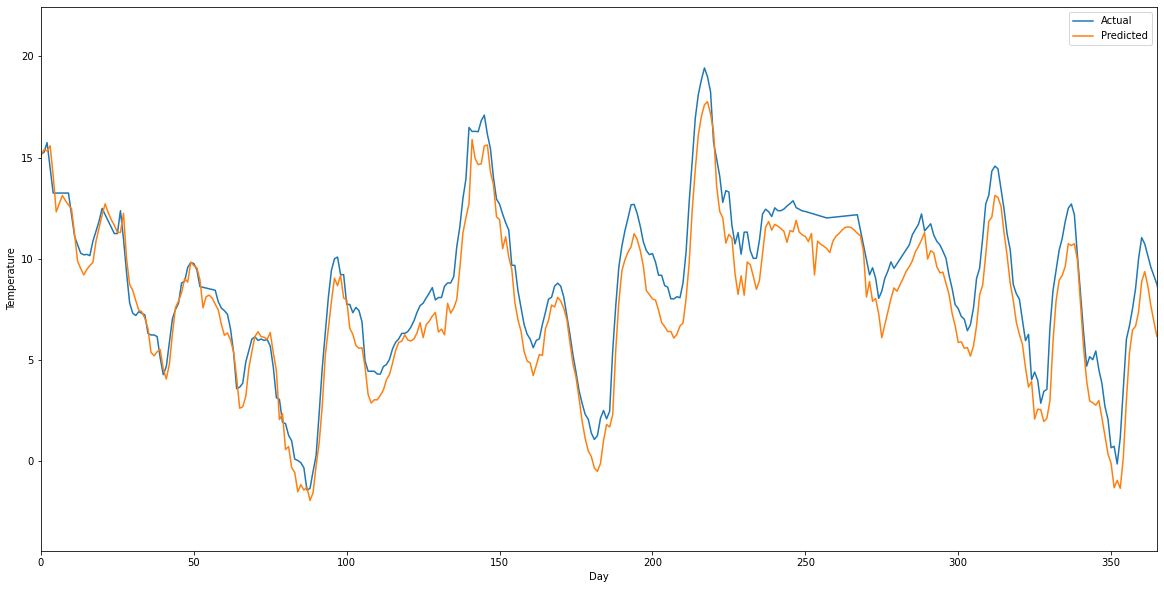

In [64]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [65]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 2.8238117028904433
R-Squared: 0.9812491071537494
RMSE: 1.6804200971454857


#### Multi-Head Attention Model

This model uses the full transformer architecture for LSTM predictions. Transformers allow for old information to be retained far more effectively than LSTM or RNN models.

In [66]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()
df['Temperature'] = df['Temperature']-273.15
df.head()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,max daily temp,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-09 19:00:00,71.861538,1016.424953,203.0,4.0,19,284.82,283.56,278.42,278.63,283.52,...,282.16,282.16,78.779569,1015.584173,285.599704,198.071006,1015.863284,1.656805,77.294310,11.82
2012-10-09 20:00:00,71.861538,1016.424953,242.0,2.0,20,284.97,284.82,277.22,279.57,283.52,...,282.16,282.16,78.779569,1015.584173,285.599588,198.329412,1015.866588,1.658824,77.262353,12.43
2012-10-09 21:00:00,71.861538,1016.424953,205.0,0.0,21,285.58,284.97,276.02,280.78,283.52,...,282.16,282.16,78.779569,1015.584173,285.600468,198.368421,1015.869853,1.649123,77.230769,12.60
2012-10-09 22:00:00,71.861538,1016.424953,217.0,0.0,22,285.75,285.58,274.95,282.35,283.52,...,282.16,282.16,78.779569,1015.584173,285.597209,198.476744,1015.873080,1.639535,77.199552,11.89
2012-10-09 23:00:00,43.000000,1024.000000,190.0,2.0,23,285.04,285.75,274.61,282.37,283.52,...,282.16,282.16,78.779569,1015.584173,285.574855,198.427746,1015.920057,1.641618,77.001867,8.58


In [67]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

In [68]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [69]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

Constructing classes for the transformers as per this kaggle example below.<br>

In [70]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer
import keras.backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass


embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="softmax")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics=['accuracy'])

In [71]:
X_train.shape

(33766, 24, 21)

Creating a transformer architecture model.

In [72]:
model_input = keras.Input(shape = X_train.shape[1:])

x = keras.layers.Bidirectional(LSTM(128, return_sequences=True))(model_input)
x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)

x, self_attn = MultiHeadAttention(n_head = 3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation='sigmoid')(conc)
model_output = Dense(1)(conc)

model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 21)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 24, 256)      153600      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 24, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 24, 192)      24576       bidirectional_1[0][0]            
____________________________________________________________________________________________

In [73]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
845/845 [==============================] - 45s 48ms/step - loss: 0.2686 - val_loss: 0.7293
Epoch 2/20
845/845 [==============================] - 40s 47ms/step - loss: 0.1689 - val_loss: 0.5093
Epoch 3/20
845/845 [==============================] - 34s 41ms/step - loss: 0.0776 - val_loss: 0.3952
Epoch 4/20
845/845 [==============================] - 34s 40ms/step - loss: 0.0592 - val_loss: 0.1058
Epoch 5/20
845/845 [==============================] - 34s 41ms/step - loss: 0.0451 - val_loss: 0.0503
Epoch 6/20
845/845 [==============================] - 34s 41ms/step - loss: 0.0629 - val_loss: 0.0565
Epoch 7/20
845/845 [==============================] - 35s 42ms/step - loss: 0.0662 - val_loss: 0.0516
Epoch 8/20
845/845 [==============================] - 36s 43ms/step - loss: 0.0364 - val_loss: 0.0556


In [74]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

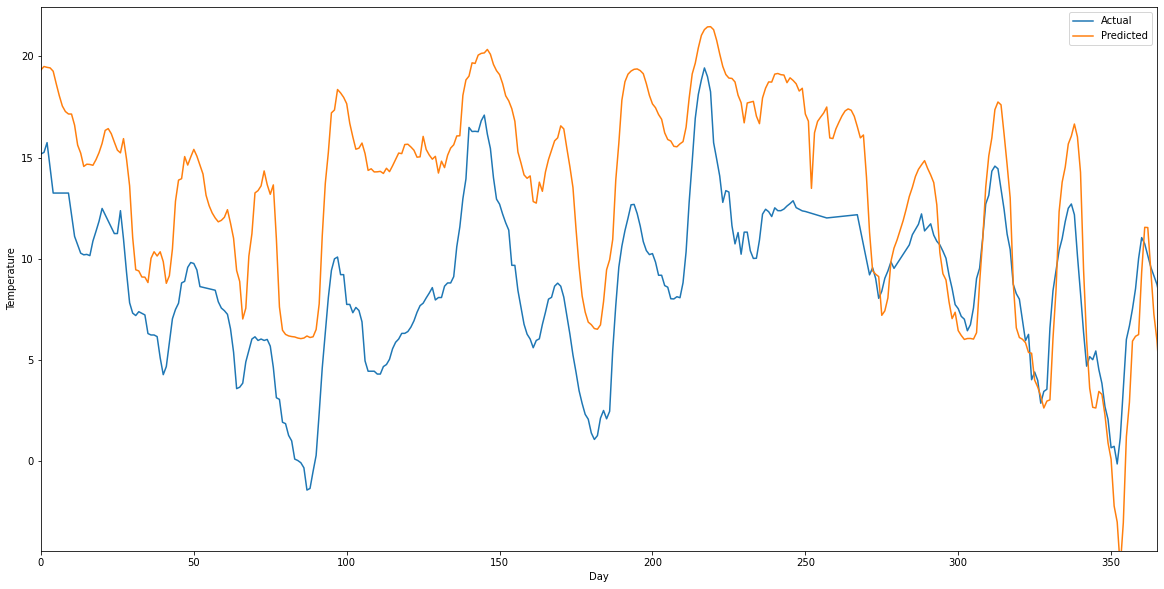

In [75]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [76]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 21.660302257007775
R-Squared: 0.856169585874717
RMSE: 4.654062983781781


This seems to perform a lot worse than some of the original models. I'm not comfortable enough with transformers to confidently explain why, but I conjecture that weather prediction is a simple problem which transformers may just be too complex a solution to effectively implement.

#### Simple Transformer

Trying transformers with just previous temperatures as inputs

In [77]:
data = load_and_preprocess()
data = data.dropna()
data['Temperature'] = data['Temperature']-273.15
df = data[['datetime', 'Temperature']]
df.head()

,datetime,Temperature
1,2012-10-01 13:00:00,12.680000
2,2012-10-01 14:00:00,12.684650
3,2012-10-01 15:00:00,12.697790
4,2012-10-01 16:00:00,12.710929
5,2012-10-01 17:00:00,12.724069


In [78]:
cutoff = int(len(df)*0.75)

train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [79]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [80]:
X_train, y_train = split(train_std, n_timestamp=24)
X_test, y_test = split(test_std, n_timestamp=24)

In [93]:
model_input = keras.Input(shape = X_train.shape[1:])

x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(model_input)
x = keras.layers.Bidirectional(LSTM(32, return_sequences=True))(x)

x, self_attn = MultiHeadAttention(n_head = 3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation='sigmoid')(conc)
model_output = Dense(1)(conc)

model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 24, 128)      33792       input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 24, 64)       41216       bidirectional_4[0][0]            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 24, 192)      12288       bidirectional_5[0][0]            
____________________________________________________________________________________________

In [94]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
848/848 [==============================] - 32s 32ms/step - loss: 0.2776 - val_loss: 0.7773
Epoch 2/20
848/848 [==============================] - 27s 32ms/step - loss: 0.2247 - val_loss: 0.6373
Epoch 3/20
848/848 [==============================] - 25s 29ms/step - loss: 0.2248 - val_loss: 0.5928
Epoch 4/20
848/848 [==============================] - 25s 29ms/step - loss: 0.2168 - val_loss: 0.6068
Epoch 5/20
848/848 [==============================] - 25s 29ms/step - loss: 0.1995 - val_loss: 0.4589
Epoch 6/20
848/848 [==============================] - 26s 30ms/step - loss: 0.1002 - val_loss: 0.1026
Epoch 7/20
848/848 [==============================] - 26s 31ms/step - loss: 0.0220 - val_loss: 0.1039
Epoch 8/20
848/848 [==============================] - 27s 32ms/step - loss: 0.0166 - val_loss: 0.0993
Epoch 9/20
848/848 [==============================] - 25s 29ms/step - loss: 0.0165 - val_loss: 0.0649
Epoch 10/20
848/848 [==============================] - 24s 28ms/step - loss: 0.015

In [95]:
y_pred = model.predict(X_test)

y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

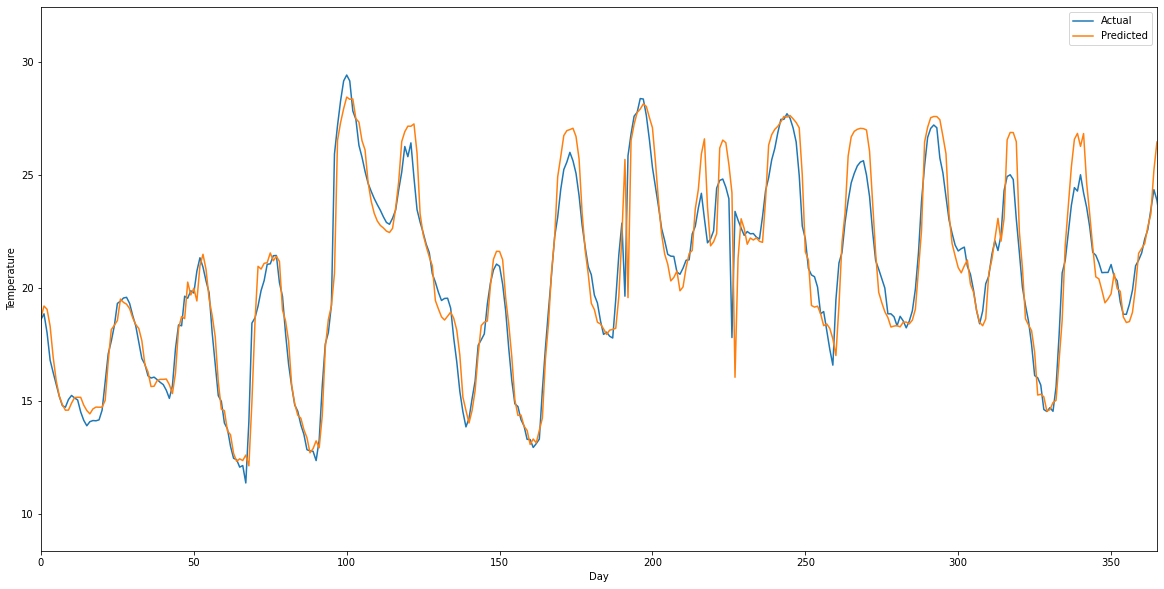

In [96]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [97]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 3.4717517520296615
R-Squared: 0.9708866274512694
RMSE: 1.8632637365734517


-----

Moving with the basic LSTM - that was the most performant model (probably because most recent temperatures are the most important indicators of future temperatures).

In [2]:
data = load_and_preprocess()
data = data.dropna()

In [3]:
df = data[['datetime', 'Temperature']]
df.head()

,datetime,Temperature
1,2012-10-01 13:00:00,285.830000
2,2012-10-01 14:00:00,285.834650
3,2012-10-01 15:00:00,285.847790
4,2012-10-01 16:00:00,285.860929
5,2012-10-01 17:00:00,285.874069


In [5]:
cutoff = int(len(df)*0.75)

In [6]:
train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [7]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [8]:
X_train, y_train = split(train_std, n_timestamp=24)
X_test, y_test = split(test_std, n_timestamp=24)

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [10]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
848/848 [==============================] - 13s 13ms/step - loss: 0.0581 - val_loss: 0.0157
Epoch 2/20
848/848 [==============================] - 10s 12ms/step - loss: 0.0144 - val_loss: 0.0063
Epoch 3/20
848/848 [==============================] - 11s 13ms/step - loss: 0.0106 - val_loss: 0.0059
Epoch 4/20
848/848 [==============================] - 10s 12ms/step - loss: 0.0103 - val_loss: 0.0057
Epoch 5/20
848/848 [==============================] - 11s 13ms/step - loss: 0.0104 - val_loss: 0.0057
Epoch 6/20
848/848 [==============================] - 11s 13ms/step - loss: 0.0104 - val_loss: 0.0059
Epoch 7/20
848/848 [==============================] - 10s 12ms/step - loss: 0.0104 - val_loss: 0.0060


In [11]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

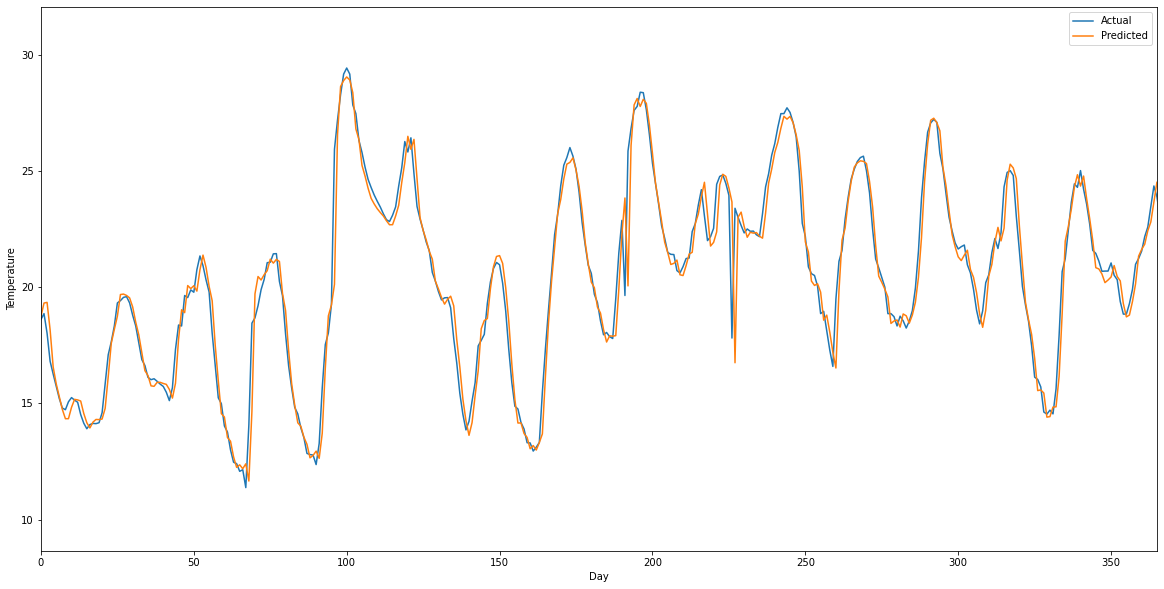

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv-273.15, label = 'Actual') #converting to C from K here
plt.plot(y_pred_inv-273.15, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([min(y_pred_inv[:366]-273.15)-3, max(y_pred_inv[:366]-273.15)+3])
plt.legend()
plt.show()

In [13]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 0.8667717711344398
R-Squared: 0.9927314360904385
RMSE: 0.9310057846944023


Custom function to build an LSTM model and test performance.

Adjusting the dataset to predict average daily temperature in order to speed up training times. This method will also likely be used in our final analysis as it is slightly more intutitive.

In [17]:
df['datetime'] = pd.to_datetime(df['datetime'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df = df.groupby(df['datetime'].dt.date).agg('mean')

In [36]:
cutoff = int(len(df)*0.75)

train = df[:cutoff].iloc[:, 0:].values
test = df[cutoff:].iloc[:, 0:].values

sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

X_train, y_train = split(train_std, 10)
X_test, y_test = split(test_std, 10)

In [39]:
X_train.shape, y_train.shape

((1405, 10, 1), (1405, 1))

We tested Ludwig in another notebook, and AutoKeras does not have time series functionality, so we're making our own hyperparameter optimization method. The models tend to perform much worse than ARIMA and XGBoost, so it is more of a formality than anything.

In [40]:
def build_lstm(X_train, n_layers = 2, cell_range = [32, 128], dropout = 0, batchnorm = False):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
    
    for i in range(n_layers-1):
        model.add(keras.layers.LSTM(random.randint(cell_range[0], cell_range[1]), return_sequences=True))
        model.add(keras.layers.Dropout(dropout))
        if batchnorm:
            model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(random.randint(cell_range[0], cell_range[1])))
    model.add(keras.layers.Dropout(dropout))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model, {'n_layers': n_layers, 'cell_min': cell_range[0], 'cell_max': cell_range[1], 'dropout': dropout, 'batchnorm': batchnorm}

In [50]:
def model_performance(model):
    history = model.fit(X_train, y_train, epochs = 25, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False, verbose = 0)
    y_pred = model.predict(X_test)
    y_pred_inv = sc.inverse_transform(y_pred)
    y_test_inv = sc.inverse_transform(y_test)
    
    return mean_squared_error(y_test_inv, y_pred_inv), r2_score(y_test_inv, y_pred_inv), math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)), np.mean(np.mean(np.abs(y_test_inv - y_pred_inv), axis=1))

Training many different models to assess performance.

In [51]:
import random
attributes = dict()
for i in range(10):
    model, atts = build_lstm(X_train, n_layers = random.randint(2, 8), cell_range = [32, 128], dropout = random.uniform(0, 0.4), batchnorm = random.choice([True, False]))
    mse, r2, rmse, mae = model_performance(model)
    atts['MSE'] = mse
    atts['R2'] = r2
    atts['RMSE'] = rmse
    atts['MAE'] = mae
    print(str(i+1)+' models tested')
    attributes[i] = atts

1 models tested
2 models tested
3 models tested
4 models tested
5 models tested
6 models tested
7 models tested
8 models tested
9 models tested
10 models tested


In [52]:
atts = pd.DataFrame.from_dict(attributes, orient='index')

In [53]:
atts

,n_layers,cell_min,cell_max,dropout,batchnorm,MSE,R2,RMSE,MAE
0,7,32,128,0.223121,True,123.530877,-0.130221,11.114445,9.671581
1,5,32,128,0.285748,True,61.317740,0.438986,7.830564,6.431103
2,8,32,128,0.183432,True,86.198924,0.211340,9.284338,7.863812
3,2,32,128,0.257688,True,81.951397,0.250202,9.052701,7.684309
4,5,32,128,0.338582,True,76.561982,0.299512,8.749970,7.293308
5,4,32,128,0.187885,True,120.410650,-0.101673,10.973179,9.515219
6,2,32,128,0.349985,False,11.784505,0.892180,3.432857,2.599712
7,7,32,128,0.220011,True,126.641644,-0.158682,11.253517,9.803537
8,5,32,128,0.177101,True,119.228944,-0.090861,10.919201,9.456601
9,4,32,128,0.077049,False,25.879920,0.763217,5.087231,3.955828


Most performant models after a lot of testing contained a small number of layers (like 2-4), and no batch normalization. Dropout did not seem to impact performance much. These models were significantly less performant than the ARIMA and XGBoost ones chosen in our other analysis, however. So, we decided to move forward with an ARIMA model that showed ~0.5-0.6 RMSE.

In [65]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 64, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64, return_sequences = True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [66]:
history = model.fit(X_train, y_train, epochs = 100, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.1, shuffle=False)

Epoch 1/100
40/40 [==============================] - 5s 31ms/step - loss: 0.5205 - val_loss: 0.1980
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2320 - val_loss: 0.1914
Epoch 3/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2260 - val_loss: 0.1804
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2182 - val_loss: 0.1769
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2165 - val_loss: 0.1733
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2128 - val_loss: 0.1683
Epoch 7/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2074 - val_loss: 0.1644
Epoch 8/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2030 - val_loss: 0.1599
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 0.1967 - val_loss: 0.1544
Epoch 10/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1904 - val_loss: 0.1498
Epo

In [67]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

In [68]:
y_pred.shape

(462, 1)

Keep in mind, this was a model with the aggregated daily temperatures.

In [69]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))

MSE: 11.015653364373865
R-Squared: 0.899214518768774
RMSE: 3.3189837848916746


### Conclusion

In summary, the best LSTM models were the simple ones which considered only previous temperatures as inputs as opposed to more complicated models with many variables. However, the LSTM and Transformer models tested perform markedly worse than the ARIMA and XGBoost models that we tested.